In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


In [297]:
df = pd.read_csv("data/topologies.csv", names=["Topology", "QueueType", "QueuePosition", "BuffersPerRouter", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMs", "Registers", "Frequency"])


In [298]:
oneHotEncoders = dict()
columnsToEncode = ["Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm"]

enc = OneHotEncoder()

enc.fit(df[columnsToEncode])

df = pd.concat([df,pd.DataFrame.sparse.from_spmatrix(enc.transform(df[columnsToEncode]))], axis=1)


In [299]:
c = -1
for i in range(len(enc.categories_)):
    for j in range(len(enc.categories_[i])):
        c += 1
        df.rename({c: enc.categories_[i][j]}, axis=1, inplace=True)


In [300]:
df.drop(columnsToEncode, inplace=True, axis=1)


In [301]:
workm = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Mesh"] == 1]

temp = workm['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
workm['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]
workm.drop(['Generatrixs'], axis=1, inplace=True)

workm["BuffersNumber"] = workm["BuffersPerRouter"]*(workm["RoutersNumber"]*5 - (temp[temp.columns[1]]+temp[temp.columns[0]])*2)

del temp


In [302]:
workt = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Torus"] == 1]

temp = workt['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
workt['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]
workt.drop(['Generatrixs'], axis=1, inplace=True)

workt["BuffersNumber"] = workt["BuffersPerRouter"]*workt["RoutersNumber"]*5

del temp


In [303]:
workc = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 1]

temp = workc['Generatrixs'].str.split(', ', n=5, expand=True).astype('uint16')
workc['RoutersNumber'] = temp.max(axis=1)
workc.drop(['Generatrixs'], axis=1, inplace=True)

workc["BuffersNumber"] = workc["BuffersPerRouter"]*workc["RoutersNumber"]*5

del temp


In [304]:
work = pd.concat([workm, workt, workc])

del workm
del workt
del workc


In [305]:
normalizerDict = dict()
for col in work.columns:
    normalizerDict[col] = MinMaxScaler()
    work[col] = normalizerDict[col].fit_transform(work[col].to_numpy().reshape(-1, 1))


Data ready

<Axes: >

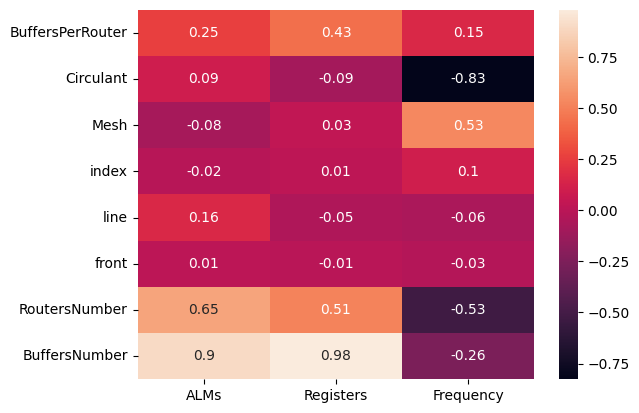

In [306]:
cor = work.corr()
cor.drop(["Mesh", "Circulant", "index", "line", "front", "BuffersNumber", "RoutersNumber", "BuffersPerRouter"], axis=1, inplace=True)
cor.drop(["ALMs", "Registers", "Frequency"], axis=0, inplace=True)
sb.heatmap(cor, annot=cor.apply(lambda x: x//0.01*0.01))


In [307]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score


In [308]:
X = work.drop(["Registers", "ALMs", "Frequency"] ,axis=1)
y = work[["Registers", "ALMs", "Frequency"]]


In [309]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)

In [310]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [311]:
model = smf.ols(formula='Registers ~ Mesh + Circulant + index + line + front + BuffersPerRouter + BuffersNumber + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Registers   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 4.315e+04
Date:                 Ср, 26 мар 2025   Prob (F-statistic):               0.00
Time:                        03:46:16   Log-Likelihood:                 10908.
No. Observations:                4429   AIC:                        -2.180e+04
Df Residuals:                    4420   BIC:                        -2.174e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0043      0.001  

In [312]:
model = smf.ols(formula='ALMs ~ Mesh + Circulant + index + line + front + BuffersPerRouter  +  BuffersNumber + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   ALMs   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 1.129e+04
Date:                 Ср, 26 мар 2025   Prob (F-statistic):               0.00
Time:                        03:46:16   Log-Likelihood:                 7195.8
No. Observations:                4429   AIC:                        -1.437e+04
Df Residuals:                    4420   BIC:                        -1.432e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0648      0.003  

In [313]:
model = smf.ols(formula='Frequency ~ Mesh + Circulant + index + line + front + BuffersPerRouter + BuffersNumber + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     4548.
Date:                 Ср, 26 мар 2025   Prob (F-statistic):               0.00
Time:                        03:46:17   Log-Likelihood:                 5959.2
No. Observations:                4429   AIC:                        -1.190e+04
Df Residuals:                    4420   BIC:                        -1.184e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6335      0.004  

In [314]:
lrR = LinearRegression()
lrR.fit(X_train, y_train["Registers"])

lrA = LinearRegression()
lrA.fit(X_train, y_train["ALMs"])

lrF = LinearRegression()
lrF.fit(X_train, y_train["Frequency"])

rP = lrR.predict(X_test)
aP = lrA.predict(X_test)
fP = lrF.predict(X_test)

print("Registers RMSE:", root_mean_squared_error(y_test["Registers"], rP), 'R2:', r2_score(y_test["Registers"], rP))
print("ALMs RMSE:", root_mean_squared_error(y_test["ALMs"], aP), 'R2:', r2_score(y_test["ALMs"], aP))
print("Frequency RMSE:", root_mean_squared_error(y_test["Frequency"], fP), 'R2:', r2_score(y_test["Frequency"], fP))


Registers RMSE: 0.02038823413840574 R2: 0.9882646690785444
ALMs RMSE: 0.04698602964440066 R2: 0.9555916691894667
Frequency RMSE: 0.05869585279967311 R2: 0.9062935159890215


In [315]:
print("Intercept", lrR.intercept_, lrA.intercept_, lrF.intercept_, )

for i in range(len(lrR.coef_)):
    print(X_train.columns[i], lrR.coef_[i], lrA.coef_[i], lrF.coef_[i], )

Intercept 0.003976934632832885 -0.06626778946339473 0.6344824860451446
BuffersPerRouter -0.056530728602421976 -0.041066161776433296 -0.3605544515443489
Circulant -0.00843242012650497 0.03342061905249641 -0.34769660560435456
Mesh -0.006928932916382066 -0.013536116342960203 0.03633687584514947
index -0.007088020381337533 0.033726876875915704 0.02751800356246714
line -0.021419453524235424 0.09332735061691379 -0.007251362274453983
front 0.006673265100524703 0.014112142882371677 -0.010421044497963411
RoutersNumber 0.05964399525207556 0.19416515302315013 -0.17785379379315217
BuffersNumber 1.069559974357645 1.100515811621448 -0.06804230514554727


Сделаем поправку на ресурсы алгоритма и арбитера

In [316]:
arb2n = pd.read_csv('data/arbiter2n.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsArb2n", "RegistersArb2n", "Frequency"], skiprows=1)
arb3n = pd.read_csv('data/arbiter3n.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsArb3n", "RegistersArb3n", "Frequency"], skiprows=1)
arb4n = pd.read_csv('data/arbiter4n.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsArb4n", "RegistersArb4n", "Frequency"], skiprows=1)
alg = pd.read_csv('data/algorithm.csv', names=["TopLevelEntity", "Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMsAlg", "RegistersAlg", "Frequency"], skiprows=1)
df = pd.read_csv("data/topologies.csv", names=["Topology", "QueueType", "QueuePosition", "BuffersPerRouter", "ArbitratorType", "Algorithm", "Generatrixs", "DataLength", "ALMs", "Registers", "Frequency"])


In [317]:
df = df.merge(arb2n[["ALMsArb2n", "RegistersArb2n", "DataLength"]], on=["DataLength"])
df = df.merge(arb3n[["ALMsArb3n", "RegistersArb3n", "DataLength"]], on=["DataLength"])
df = df.merge(arb4n[["ALMsArb4n", "RegistersArb4n", "DataLength"]], on=["DataLength"])
df = df.merge(alg[["ALMsAlg", "RegistersAlg", "DataLength", "Algorithm", "Topology"]], on=["DataLength", "Algorithm", "Topology"])


In [318]:
oneHotEncoders = dict()
columnsToEncode = ["Topology", "QueueType", "QueuePosition", "ArbitratorType", "Algorithm"]

enc = OneHotEncoder()

enc.fit(df[columnsToEncode])

df = pd.concat([df,pd.DataFrame.sparse.from_spmatrix(enc.transform(df[columnsToEncode]))], axis=1)


In [319]:
c = -1
for i in range(len(enc.categories_)):
    for j in range(len(enc.categories_[i])):
        c += 1
        df.rename({c: enc.categories_[i][j]}, axis=1, inplace=True)


In [320]:
df.drop(columnsToEncode, inplace=True, axis=1)


In [321]:
workm = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Mesh"] == 1]

temp = workm['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
workm['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]
workm.drop(['Generatrixs'], axis=1, inplace=True)

workm["BuffersNumber"] = workm["BuffersPerRouter"]*(workm["RoutersNumber"]*5 - (temp[temp.columns[1]]+temp[temp.columns[0]])*2)

workm["gen1"] = temp[temp.columns[0]]
workm["gen2"] = temp[temp.columns[1]]

del temp


In [322]:
workt = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Torus"] == 1]

temp = workt['Generatrixs'].str.split(', ', n=1, expand=True).astype('uint16')
workt['RoutersNumber'] = temp[temp.columns[1]]*temp[temp.columns[0]]
workt.drop(['Generatrixs'], axis=1, inplace=True)

workt["BuffersNumber"] = workt["BuffersPerRouter"]*workt["RoutersNumber"]*5

del temp


In [323]:
workc = df.drop(["DataLength", "pointer", "rear", "round_robin", "xy", "Torus", "ga"], axis=1)[df["Circulant"] == 1]

temp = workc['Generatrixs'].str.split(', ', n=5, expand=True).astype('uint16')
workc['RoutersNumber'] = temp.max(axis=1)
workc.drop(['Generatrixs'], axis=1, inplace=True)

workc["BuffersNumber"] = workc["BuffersPerRouter"]*workc["RoutersNumber"]*5

del temp


In [324]:
work = pd.concat([workm, workt, workc])

del workm
del workt
del workc


In [325]:
work["ALMs"] -= work["ALMsAlg"]*work["RoutersNumber"]
work["Registers"] -= work["RegistersAlg"]*work["RoutersNumber"]

work[work["Mesh"] == 0]["ALMs"] -= work[work["Mesh"] == 0]["ALMsArb4n"]*work[work["Mesh"] == 0]["RoutersNumber"]
work[work["Mesh"] == 0]["Registers"] -= work[work["Mesh"] == 0]["RegistersArb4n"]*work[work["Mesh"] == 0]["RoutersNumber"]

work[work["Mesh"] == 1]["ALMs"] -= work[work["Mesh"] == 1]["ALMsArb4n"]*((work["gen1"]-1)*(work["gen2"]-1))
work[work["Mesh"] == 1]["ALMs"] -= work[work["Mesh"] == 1]["ALMsArb3n"]*((work["gen1"] + work["gen2"])*2 - 4 - 4)
work[work["Mesh"] == 1]["ALMs"] -= work[work["Mesh"] == 1]["ALMsArb2n"]*4

work[work["Mesh"] == 1]["Registers"] -= work[work["Mesh"] == 1]["RegistersArb4n"]*(work[work["Mesh"] == 1]["RoutersNumber"] - (work[work["Mesh"] == 1]["gen1"] + work[work["Mesh"] == 1]["gen2"])*2 + 4)
work[work["Mesh"] == 1]["Registers"] -= work[work["Mesh"] == 1]["RegistersArb3n"]*((work[work["Mesh"] == 1]["gen1"] + work[work["Mesh"] == 1]["gen2"]) - 4 - 4)
work[work["Mesh"] == 1]["Registers"] -= work[work["Mesh"] == 1]["RegistersArb2n"]*4

work.drop(columns=["gen1", "gen2", "ALMsArb2n", "RegistersArb2n", "ALMsArb3n", "RegistersArb3n", "ALMsArb4n", "RegistersArb4n", "ALMsAlg", "RegistersAlg"], inplace=True)

/tmp/ipykernel_3610/355346125.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  work[work["Mesh"] == 0]["ALMs"] -= work[work["Mesh"] == 0]["ALMsArb4n"]*work[work["Mesh"] == 0]["RoutersNumber"]
/tmp/ipykernel_3610/355346125.py:4: SettingWit

Удаление закончено

In [326]:
normalizerDict = dict()
for col in work.columns:
    normalizerDict[col] = MinMaxScaler()
    work[col] = normalizerDict[col].fit_transform(work[col].to_numpy().reshape(-1, 1))


<Axes: >

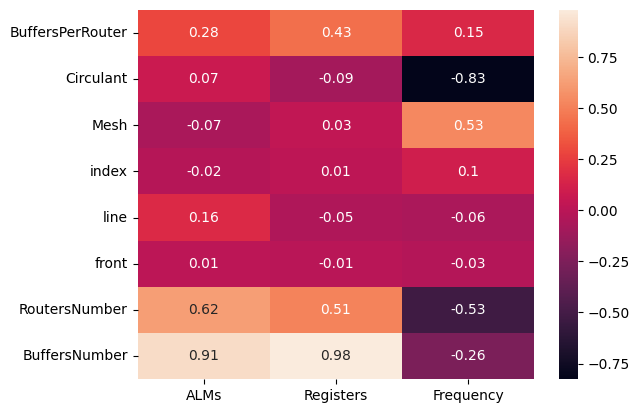

In [327]:
cor = work.corr()
cor.drop(["Mesh", "Circulant", "index", "line", "front", "BuffersNumber", "RoutersNumber", "BuffersPerRouter"], axis=1, inplace=True)
cor.drop(["ALMs", "Registers", "Frequency"], axis=0, inplace=True)
sb.heatmap(cor, annot=cor.apply(lambda x: x//0.01*0.01))


In [328]:
X = work.drop(["Registers", "ALMs", "Frequency"] ,axis=1)
y = work[["Registers", "ALMs", "Frequency"]]


In [329]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=228)

In [330]:
model = smf.ols(formula='Registers ~ Mesh + Circulant + index + line + front + BuffersNumber + BuffersPerRouter + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Registers   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 4.315e+04
Date:                 Ср, 26 мар 2025   Prob (F-statistic):               0.00
Time:                        03:46:17   Log-Likelihood:                 10908.
No. Observations:                4429   AIC:                        -2.180e+04
Df Residuals:                    4420   BIC:                        -2.174e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0043      0.001  

In [331]:
model = smf.ols(formula='ALMs ~ Mesh + Circulant + index + line + front + BuffersPerRouter  +  BuffersNumber + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   ALMs   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                 1.075e+04
Date:                 Ср, 26 мар 2025   Prob (F-statistic):               0.00
Time:                        03:46:17   Log-Likelihood:                 7138.5
No. Observations:                4429   AIC:                        -1.426e+04
Df Residuals:                    4420   BIC:                        -1.420e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0644      0.003  

In [332]:
model = smf.ols(formula='Frequency ~ Mesh + Circulant + index + line + front + BuffersPerRouter + BuffersNumber + RoutersNumber', data=work).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     4548.
Date:                 Ср, 26 мар 2025   Prob (F-statistic):               0.00
Time:                        03:46:17   Log-Likelihood:                 5959.2
No. Observations:                4429   AIC:                        -1.190e+04
Df Residuals:                    4420   BIC:                        -1.184e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6335      0.004  

In [333]:
lrR = LinearRegression()
lrR.fit(X_train, y_train["Registers"])

lrA = LinearRegression()
lrA.fit(X_train, y_train["ALMs"])

lrF = LinearRegression()
lrF.fit(X_train, y_train["Frequency"])

rP = lrR.predict(X_test)
aP = lrA.predict(X_test)
fP = lrF.predict(X_test)

print("Registers RMSE:", root_mean_squared_error(y_test["Registers"], rP), 'R2:', r2_score(y_test["Registers"], rP))
print("ALMs RMSE:", root_mean_squared_error(y_test["ALMs"], aP), 'R2:', r2_score(y_test["ALMs"], aP))
print("Frequency RMSE:", root_mean_squared_error(y_test["Frequency"], fP), 'R2:', r2_score(y_test["Frequency"], fP))


Registers RMSE: 0.02038823413840574 R2: 0.9882646690785444
ALMs RMSE: 0.04759316424313531 R2: 0.953536161668596
Frequency RMSE: 0.05869585279967311 R2: 0.9062935159890215


In [334]:
print("Intercept", lrR.intercept_, lrA.intercept_, lrF.intercept_, )

for i in range(len(lrR.coef_)):
    print(X_train.columns[i], lrR.coef_[i], lrA.coef_[i], lrF.coef_[i], )

Intercept 0.003976934632832885 -0.06577323959615694 0.6344824860451446
BuffersPerRouter -0.056530728602421976 -0.0443048747527436 -0.3605544515443489
Circulant -0.00843242012650497 0.0308890636015203 -0.34769660560435456
Mesh -0.006928932916382066 -0.013587029371852716 0.03633687584514947
index -0.007088020381337533 0.034286372495360845 0.02751800356246714
line -0.021419453524235424 0.09483030985038265 -0.007251362274453983
front 0.006673265100524703 0.014323869725813345 -0.010421044497963411
RoutersNumber 0.05964399525207556 0.16577221442287174 -0.17785379379315217
BuffersNumber 1.069559974357645 1.1212469596407928 -0.06804230514554727
